In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

### Ratings file
Each line contains a rated video game:

- a user
- an item
- a rating from 1 to 5

In [2]:
raw_ratings = pd.read_csv('ratings_latest.csv', sep=',')

raw_ratings.head()

,id,rate,appid
0,76561197960265729,1.0,10
1,76561197960265729,1.0,20
2,76561197960265729,1.0,30
3,76561197960265729,1.0,40
4,76561197960265729,1.0,50


### Metadata file

This file contains information about each game, specifically:
- item
- name
- genres

In [3]:
items = pd.read_csv('metadata.csv', sep=',')

items.head()

,appid,appname,genres
0,10,Counter-Strike,1/
1,20,Team Fortress Classic,1/
2,30,Day of Defeat,1/
3,40,Deathmatch Classic,1/
4,50,Half-Life: Opposing Force,1/


In [4]:
all_ratings = pd.merge(items, raw_ratings)

all_ratings.head()

,appid,appname,genres,id,rate
0,10,Counter-Strike,1/,76561197960265729,1.00
1,10,Counter-Strike,1/,76561197960265730,2.05
2,10,Counter-Strike,1/,76561197960265731,1.00
3,10,Counter-Strike,1/,76561197960265733,1.40
4,10,Counter-Strike,1/,76561197960265734,1.00


### Data pre-analysis
Survey the data and analyze its distribution and statistics. The following are computed:

- number of users
- number of items
- rating distribution

In [5]:
all_ratings['rate'].describe()

count    2.573393e+07
mean     1.275410e+00
std      7.960212e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.100000e+00
max      5.950000e+00
Name: rate, dtype: float64

#### Maximum Stats

In [6]:
print(all_ratings['id'].value_counts().index.tolist()[0])
print(all_ratings['id'].value_counts().tolist()[0])

76561197973009892
10440


User 76561197973009892 contains the most games in our dataset, with more than 10440 ratings.

In [7]:
print(all_ratings['appid'].value_counts().index.tolist()[0])
print(all_ratings['appid'].value_counts().tolist()[0])

340
364650


Game 15 has the most ownerships, with 364.650 owners, or about 53.89% of our user dataset.

#### User Game Statistics

In [8]:
users_nb = all_ratings['id'].value_counts().reset_index()
users_nb.columns= ['id','nb_lines']
users_nb['nb_lines'].describe()

count    676668.000000
mean         38.030361
std         123.929002
min           1.000000
25%           4.000000
50%           8.000000
75%          22.000000
max       10440.000000
Name: nb_lines, dtype: float64

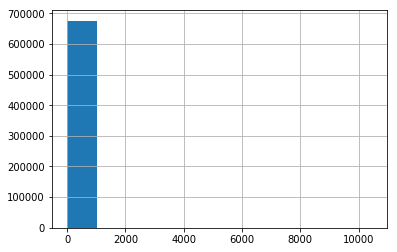

In [9]:
import seaborn
users_nb['nb_lines'].hist()

Half the user dataset owns not more than 8 games.

#### Game ownership stats

In [10]:
games_nb = all_ratings['appid'].value_counts().reset_index()
games_nb.columns= ['appid','nb_lines']
games_nb['nb_lines'].describe()

count     18865.000000
mean       1364.109621
std        8333.452088
min           1.000000
25%          13.000000
50%          86.000000
75%         510.000000
max      364650.000000
Name: nb_lines, dtype: float64

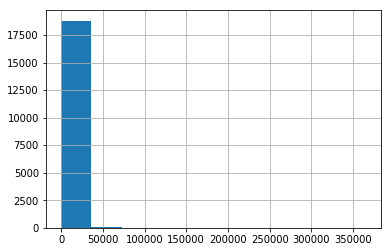

In [11]:
games_nb['nb_lines'].hist()

Half of the game dataset has no more than 86 ownerships

### Data pre-processing

In [12]:
users = all_ratings.id.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}


games = all_ratings.appid.unique()
game_map = {i:val for i,val in enumerate(games)}
inverse_game_map = {val:i for i,val in enumerate(games)}

all_ratings["id"] = all_ratings["id"].map(inverse_user_map)

all_ratings["old_id"] = all_ratings["appid"] # copying for join with metadata
all_ratings["appid"] = all_ratings["appid"].map(inverse_game_map)

print ("A total of: ", users.shape[0], "unique users")
print ("A total of: ", games.shape[0], "unique games")

A total of:  676668 unique users
A total of:  18865 unique games


In [13]:
all_ratings.sort_values('rate', ascending=False).head(10)

,appid,appname,genres,id,rate,old_id
543073,2,Day of Defeat,1/,100887,5.95,30
2433028,11,Counter-Strike: Source,1/,364830,5.95,240
13934442,1625,Football Manager 2013™,28/18/,560547,5.95,207890
25295968,13817,PLAYERUNKNOWN'S BATTLEGROUNDS,73/1/25/29/,475864,5.95,578080
6266506,283,BioShock Infinite,1/,428206,5.95,8870
23728290,8791,Raw Data,1/23/2/,280654,5.95,436320
6827805,333,Call of Duty®: Modern Warfare® 2,1/,446221,5.95,10190
24754130,11471,Panzer Warfare,1/4/23/29/28/2/70/,358534,5.95,513880
9434766,811,Arma 2: Operation Arrowhead,1/28/2/,404183,5.95,33930
18807596,2846,XCOM® 2,2/,45380,5.95,268500


In [14]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

In [15]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction 
config.gpu_options.visible_device_list = "0" # "0,1"
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [16]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Reshape
from keras.layers.merge import Multiply
from keras.layers.merge import Dot
from keras.layers.embeddings import Embedding
from keras import optimizers

In [17]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=games.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

y = Dot(1, normalize=False)([user_vecs, item_vecs])

model = Model(inputs=[user_id_input, item_id_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam"
             )

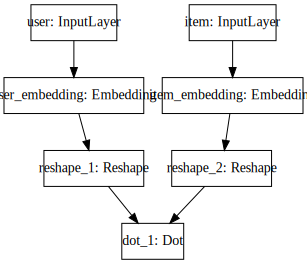

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import pydot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [19]:
# import time
# from keras.callbacks import ModelCheckpoint
# mainpath = '/Desktop/vidyarecsys/preprocessing/game_mf'
# save_path = mainpath + "/models"
# mytime = time.strftime("%Y_%m_%d_%H_%M")
# modname = 'matrix_facto_50_' + mytime 
# thename = save_path + '/' + modname + '.h5'
# mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

In [20]:

# %%time

# # Training the model
# history = model.fit([user_id_train, item_id_train], rating_train,
#                     batch_size=64, nb_epoch=6, validation_split=0.1,
#                     shuffle=True, verbose=2)

In [21]:
# %%time

# history = model.fit([ratings_train["id"], ratings_train["appid"]]
#                     , ratings_train["rate"]
#                     , batch_size=64, epochs=6
#                     , validation_split=0.1
#                     , verbose = 2
#                     , shuffle=True)

,0,1,2,3,4,5
loss,0.730734,0.511032,0.433186,0.366968,0.319570,0.286745
val_loss,0.577849,0.558213,0.562738,0.573166,0.578577,0.579778


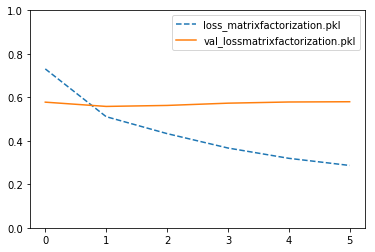

In [22]:

histories = ['matrixfactorization.pkl']

import pickle
for val in histories:
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
plt.legend()
plt.ylim(0, 1)

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

In [23]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Reshape, Dropout, Dense
from keras.layers.merge import Multiply, Dot
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate
from keras import optimizers

In [24]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 10 # 5
user_embedding = Embedding(output_dim=embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=games.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs])

x = Dense(128, activation='relu')(input_vecs)
# x = Dense(128, activation='relu')(x)

y = Dense(1)(x)


model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='mse')

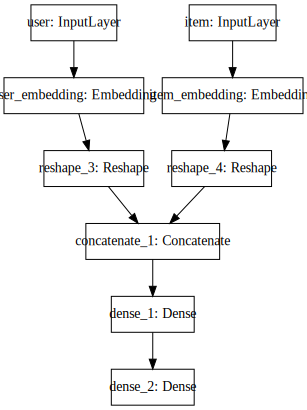

In [25]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        6766680     user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        188650      item[0][0]                       
__________________________________________________________________________________________________
reshape_3 

In [27]:
initial_train_preds_nn = model.predict([ratings_train["id"], ratings_train["appid"]])

In [28]:
%%time

history = model.fit([ratings_train["id"], ratings_train["appid"]]
                    , ratings_train["rate"]
                    , batch_size=64, epochs=20
                    , validation_split=0.1
                    , verbose = 2
                    , shuffle=True)


Train on 18528427 samples, validate on 2058715 samples
Epoch 1/20
 - 19818s - loss: 0.3986 - val_loss: 0.3829
Epoch 2/20
 - 17546s - loss: 0.3593 - val_loss: 0.3860
Epoch 3/20
 - 17477s - loss: 0.3248 - val_loss: 0.3978
Epoch 4/20
 - 17095s - loss: 0.2998 - val_loss: 0.4074
Epoch 5/20
 - 17428s - loss: 0.2836 - val_loss: 0.4115
Epoch 6/20
 - 17192s - loss: 0.2722 - val_loss: 0.4229
Epoch 7/20
 - 17216s - loss: 0.2639 - val_loss: 0.4327
Epoch 8/20
 - 17255s - loss: 0.2573 - val_loss: 0.4317
Epoch 9/20
 - 17337s - loss: 0.2523 - val_loss: 0.4322
Epoch 10/20
 - 17293s - loss: 0.2478 - val_loss: 0.4401
Epoch 11/20
 - 17289s - loss: 0.2439 - val_loss: 0.4413
Epoch 12/20
 - 17291s - loss: 0.2407 - val_loss: 0.4382
Epoch 13/20
 - 17362s - loss: 0.2378 - val_loss: 0.4467
Epoch 14/20
 - 17162s - loss: 0.2354 - val_loss: 0.4416
Epoch 15/20
 - 17171s - loss: 0.2329 - val_loss: 0.4465
Epoch 16/20
 - 17317s - loss: 0.2308 - val_loss: 0.4483
Epoch 17/20
 - 17310s - loss: 0.2288 - val_loss: 0.4528
Ep

In [32]:
import pickle

with open('dnn128.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,0.398597,0.359286,0.324826,0.299793,0.283607,0.272215,0.263869,0.257318,0.25228,0.247778,0.243932,0.240661,0.237843,0.235421,0.232938,0.230827,0.228789,0.226941,0.225273,0.223692
val_loss,0.382918,0.385976,0.397781,0.407435,0.411524,0.422861,0.432653,0.431707,0.43221,0.440083,0.441315,0.438185,0.446721,0.441569,0.446526,0.448330,0.452821,0.458661,0.457013,0.450314


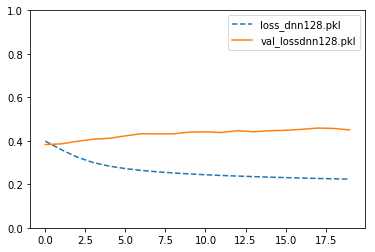

In [33]:
histories = ['dnn128.pkl']

import pickle
for val in histories:
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
plt.legend()
plt.ylim(0, 1)

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()